In [225]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.gridspec as gridspec
import time
import pandas
import scipy.stats as st
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize

In [226]:
def model(x,olambda,omega_m ):
    print(olambda,omega_m)
    cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda-omega_m )
    x = x[0]
    DL = cosmo.luminosity_distance(x)
    distanceModulus = 5 * np.log10(DL.value)+25
    return distanceModulus

In [227]:
file = pandas.read_csv("supernovaData.csv")
sigma = np.mean(file['sigma'])
len(file['sigma'])
data = [file['redshift'],file['modDist']]

In [228]:
L = 1. #Range of x-data
M = 100 # Number of data points
x = file['redshift']

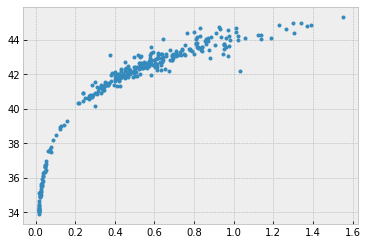

In [229]:
plt.plot(file['redshift'],file['modDist'],'.')

In [259]:
def logprior(theta,cmin,cmax,mmin,mmax,):
    ''' The natural logarithm of the prior probability. '''
    lp = 0.
    # unpack the model parameters from the tuple
    olambda, om = theta

    # uniform prior on c
    

    cmin = 0. # lower range of prior
    cmax = 1-olambda-om# upper range of prior
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < om < cmax else -np.inf
    
     # uniform prior on m
    mmin = 0. # lower range of prior
    mmax = 1-olambda-om  # upper range of prior
  
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp += 0. if mmin < olambda < mmax else -np.inf
    
    return lp

In [250]:
def loglike(theta, data, sigma, x):
    '''The natural logarithm of the likelihood.'''
    # unpack the model parameters
    
    olambda, om = theta
    cmin = 0. # lower range of prior
    cmax = 1-olambda-om# upper range of prior
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lp = 0. if cmin < om < cmax else -np.inf
    
     # uniform prior on m
    mmin = 0. # lower range of prior
    mmax = 1-olambda-om  # upper range of prior
  
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range
    lin_md = model(x,olambda,om) if mmin < olambda < mmax else -np.inf
    # evaluate the model
    
    # return the log likelihood
    return -0.5 * np.sum(((lin_md - data[1])/sigma)**2)


In [232]:
def logpost(theta, data, sigma, x,cmin,cmax,mmin,mmax,):
    '''The natural logarithm of the posterior.'''
    return logprior(theta,cmin,cmax,mmin,mmax,) + loglike(theta, data, sigma, x)

In [233]:
nwalkers = 10 # Number of walkers to use. It should be at least twice the number of dimensions.
nsteps = 5000 # Number of steps/iterations.
start = 0.01 * np.random.randn(nwalkers,2) # Initial positions of the walkers.
t0 = time.time()
samples = 0.01 * np.random.randn(len(x),2)


In [260]:

    
def guassian_proposal(theta_curr):
    # proposal based on Gaussian
    theta_new = 0.07*np.abs(st.norm(loc=theta_curr, scale=0.2).rvs())
    return theta_new

def guassian_proposal_prob(x1, x2):
    # calculate proposal probability q(x2|x1), based on Gaussian
    q =  0.07*np.abs(st.norm(loc=x1, scale=1).pdf(x2))
    return q

def mcmc_mh_posterior(X, theta_init,sigma,x,nwalkers, cmin,cmax,mmin,mmax,func, proposal_func, proposal_func_prob, n_iter=1000):
    # Metropolis-Hastings to estimate posterior
    chains = []
    for j in range(nwalkers):
        thetas = []
        print(theta_init)
        theta_curr = theta_init[j]
        accept_rates = []
        accept_cum = 0
        
        for i in range(1, n_iter+1):
            theta_new = .8*proposal_func(theta_curr)

            prob_curr = func(theta_curr,X,sigma,x,cmin,cmax,mmin,mmax,)
            
            prob_new = func(theta_new,X,sigma,x,cmin,cmax,mmin,mmax,)
            
            # we calculate the prob=exp(x) only when prob<1 so the exp(x) will not overflow for large x
    
            if prob_new > prob_curr:
                acceptance_ratio = 1,1
            else:
                qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
                
                acceptance_ratio = .8*np.exp(prob_new - prob_curr) * qr
            acceptance_prob = min(1, acceptance_ratio[0]),min(1, acceptance_ratio[1])
            
            if acceptance_prob[0] > st.uniform(0,1).rvs() and acceptance_prob[1] > st.uniform(0,1).rvs():
                theta_curr = theta_new
                accept_cum = accept_cum+1
                thetas.append(theta_new)
            else:
                thetas.append(theta_curr)
                
            accept_rates.append(accept_cum/i)
        chains.append(thetas)
        
    return chains, accept_rates


# generate observed data
X = data
nwalkers = 4
ndim = 2
cmin = .5
cmax = 1.5
mmin = 2
mmax = 5
initSamples = [ np.abs(.5*np.random.randn(nwalkers,2))]

# run MCMC
thetas, accept_rates = mcmc_mh_posterior(X, initSamples[0],sigma,x, nwalkers,cmin,cmax,mmin,mmax,
                                         logpost, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=10)


[[0.92754482 0.19106004]
 [0.20009002 0.18661354]
 [0.28407509 0.1039847 ]
 [0.15713372 0.09111511]]
0.0434980805742523 0.0018248153746705524
0.0434980805742523 0.0018248153746705524
0.0031328939592118847 0.005053696431962606
0.0434980805742523 0.0018248153746705524
0.0043377473684584 0.017215916871323966
0.0434980805742523 0.0018248153746705524
0.010172035709965907 0.00014154261408458202
0.0434980805742523 0.0018248153746705524
0.01698989177976332 0.007791162146102056
0.0434980805742523 0.0018248153746705524
0.005166427887102246 0.0007387030658227889
0.0434980805742523 0.0018248153746705524
0.006082949486834157 0.0009202425628051675
0.0434980805742523 0.0018248153746705524
0.020957083059589973 0.0032514668797407713
0.0434980805742523 0.0018248153746705524
0.003984825313095666 0.005512755243136331
0.0434980805742523 0.0018248153746705524
0.00648603697455603 0.024064411709983472
[[0.92754482 0.19106004]
 [0.20009002 0.18661354]
 [0.28407509 0.1039847 ]
 [0.15713372 0.09111511]]
0.200090

In [261]:
m_theta = []
c_theta = []
chains = []
for i in range(nwalkers):
    m_theta = []
    c_theta = []
    for j in range(len(thetas[0])):
        c_theta.append(thetas[i][j][0])
        m_theta.append(thetas[i][j][1])
    chains.append([c_theta,m_theta]) 

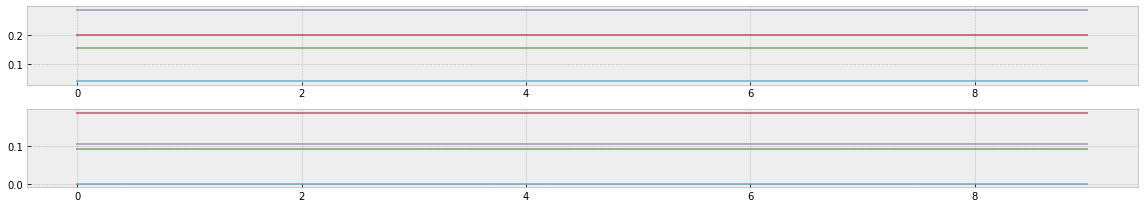

In [262]:


plt.figure(figsize=(16,1.5*ndim))

for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    for i in range(nwalkers):
        plt.plot(chains[i][n][:], '-',alpha=0.5)
plt.tight_layout()
plt.show()

In [263]:
import seaborn as sns
import pandas
m = []
c = []
for i in range(len(chains[0][0])):
    meanM = []
    meanC = []
    for j in range(nwalkers):
        meanM.append(chains[j][1][i])
        meanC.append(chains[j][0][i])
    m.append(np.mean(meanM))
    c.append(np.mean(meanC))
m_fit = max(m)
c_fit = max(c) 

d = {'c': c, 'm': m}
c_fit = max(d['c']) 
chainData = pandas.DataFrame(d)
print(chainData)


          c         m
0  0.171199  0.095885
1  0.171199  0.095885
2  0.171199  0.095885
3  0.171199  0.095885
4  0.171199  0.095885
5  0.171199  0.095885
6  0.171199  0.095885
7  0.171199  0.095885
8  0.171199  0.095885
9  0.171199  0.095885


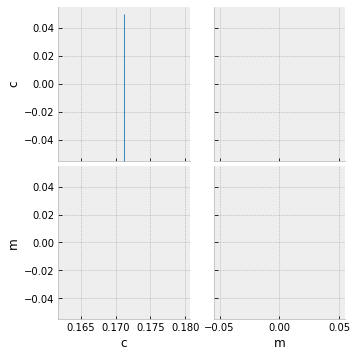

In [264]:
#sns.pairplot(chainData, kind="kde")
plt.style.use('bmh')
g = sns.pairplot(chainData, kind="kde")
i = 0
plt.show()


ValueError: 'x' and 'y' must have the same size

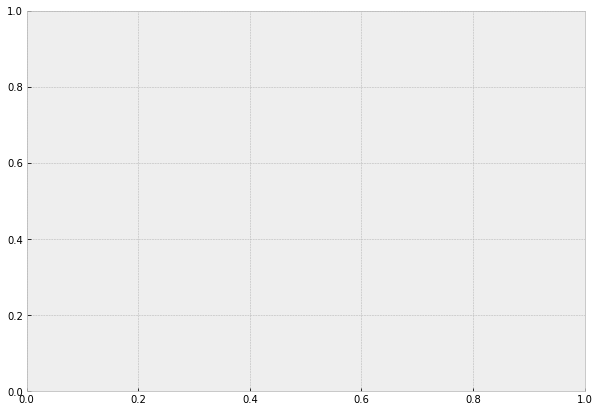

In [256]:
###
fig,ax1=plt.subplots(1,1,figsize=(10,7))
gs=gridspec.GridSpec(1,1)
colors=['b','orange']
###
ax1=plt.subplot(gs[0])
# inds = np.random.randint(len(chains[:][1]), size=100)
# for ind in inds:
#     sample = chains[ind]
#     ax1.plot(x, np.dot(np.vander(x, 2), sample[:2]),colors[0], alpha=0.1)

ax1.errorbar(x, data, yerr=sigma, fmt="o")
ax1.plot(x, straight_line(x,m_true,c_true), 'k--', label="truth")
ax1.plot(x, straight_line(x,m_fit,c_fit-cmin), 'k', label="linear fit")


###

ax1.legend(fontsize=14)
models = ['linear model', 'quadratic model']
ax1.set_ylabel(r'y')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)